# PatchTST Model Development

In this section we will develop the PatchTST model to predict S&P Close, Dow Jones Close.

## Model Congfiguration 

We will configure the PatchTST model based on the `Economic_Data_1994_2025` dataset we processed

In [2]:
from transformers import PatchTSTConfig, PatchTSTForPrediction, PatchTSTForPretraining
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch

/opt/anaconda3/envs/Personal_Proj/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [79]:
# For faster development
device = torch.device('mps')
device

device(type='mps')

In [80]:
dataset = pd.read_csv('../data/Economic_Data_1994-2025.csv')
dataset = dataset.drop(['DATE', 'Unnamed: 0'], axis=1)

## Understanding PatchTST

- **Context Length**

    Context length is how far we look back in total. If we were trying to predict the closing price for the SP500 tomorrow, our context length would be how far we look back to make our prediction.

- **Patch Length**

    Patch length is like a subset of our context length. When looking at our entire context length, patch length is the looking at each individual week up until tomorrow to make our final prediction

- **Patch Stride**

    Patch stride is how far our patch length will move after observing an individual week. We can overlap weeks to see any comparisons.
    
For each batch we will pass N amount of rows. Each row has previous rows (context length) attached to it. For each row & it's context length we pass it into our model to train on. During the training process we will used. masked forecasting. This will mask the last portion of our patch's for the model to predict. It then check's it's guesses and updates its weights accordingly.

## PreTraining Model

The pre-training model will learn ***every*** column in our dataset from all dates. This will help the model develop relationships between all variables. 

In [90]:
# How many features we are including 
NUM_INPUT = len(dataset.columns)

# Batch size for training
BATCH_SIZE = 16

# For What we are predicting
NUM_TARGET = 2

# How many steps we take in the context length
CONTEXT_LEN = 60

# How many steps we take in the context length
PATCH_LEN = 5

# How far we move our patch length
PATCH_STRD = 4

# How our model is trained
MASK_TYPE = 'forecast'

# How many items are masked in our forcast
NUM_PATCH = [int(BATCH_SIZE * .2)] # 20% of our batch

# Configuring Model
pretrain_config = PatchTSTConfig(
    num_input_channels = NUM_INPUT,
    context_length = CONTEXT_LEN,
    patch_length = PATCH_LEN,
    stride = PATCH_STRD,
    mask_type='forecast',
    num_forecast_mask_patches = NUM_PATCH
    do_mask_input=False
)

pretrain_model = PatchTSTForPretraining(pretrain_config)

Here we are splitting up our data into 2 portions. A `test` set and a `train` set. The test set is used to evalute our model based on training from the train set

We split it 80/10/10, where 80% of our data is training data, and 10% of our data is testing, and 10% is validation for each epoch.

In [91]:
# Set up constraints for development
num_train = int(len(dataset) * .8)
num_test = int(len(dataset) * .1)
num_val = int(len(dataset) * .1)

# Breaking up the data into train/test sets.
train = dataset[0: num_train]
test = dataset[num_train:num_test + num_train]
val = dataset[num_test+num_train:(num_test+num_train) + num_val]

This portion here grabs context windows for all rows in our train/test sets

In [92]:
# Creates a context window for each data point to feed into the model during training
def create_sequence_windows(data, window_size):
    windows = []
    
    # We start in the dataFrame at an index 'window_size' and look back depending on the window size
    # We will grab a context window for all data points
    for i in range(len(data) - window_size + 1):
        windows.append(data.iloc[i:i+window_size].values)
    return np.array(windows)

train_windows = create_sequence_windows(train, CONTEXT_LEN)
test_windows = create_sequence_windows(test, CONTEXT_LEN)
val_windows = create_sequence_windows(val, CONTEXT_LEN)

In [93]:
# Puts our data in PyTorch tensors for proper data types during training
past_values_train = torch.tensor(train_windows, dtype=torch.float32)
past_values_test = torch.tensor(test_windows, dtype=torch.float32)
past_values_val = torch.tensor(val_windows, dtype=torch.float32)

Preparing our data to be passed into our model for pre training

In [94]:
# Puts the tensors in a dataset for the dataloader to properly use
data_train = TensorDataset(past_values_train)

# Divides our data into batches based on the BATCH_SIZE
dataloader_train = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)

data_test = TensorDataset(past_values_test)
dataloader_test = DataLoader(data_test, batch_size=BATCH_SIZE)

data_val = TensorDataset(past_values_val)
dataloader_val = DataLoader(data_val, batch_size=BATCH_SIZE)

In [95]:
pretrain_model = pretrain_model.to(device)

### Pre-Training

Here we are training our model by doing the following:

1. Divide Training into Epoch
    - For each epoch we:
        - Set model to train mode
        - Pass in all of our data one batch size at a time
        - After training on a patch we update our parameters
        - Put our model into evaluation mode
        - Test on our validation set and print results to output
2. Final Train
    - Once we pass through all epochs we do a final test on our
        never seen data, `test` set. 
    - We iterate through our data one batch size at a time and evaluate the model
        one last time

In [96]:
optimizer = torch.optim.Adam(pretrain_model.parameters(), lr=.001)
epochs = 10


for epoch in range(epochs):

    # Allows for progress bar during training per epoch
    loop = tqdm(dataloader_train, leave=True)
    losses = []
    
    for batch in loop:
        
        # Puts model in train mode
        pretrain_model.train()
        
        # Clears any previous gradient calculations
        optimizer.zero_grad()
        
        # Transfers batch onto GPU for faster processing
        past_values = batch[0].to(device)
        
        # Foward pass through our model, generates predictions
        outputs = pretrain_model(past_values=past_values)
        
        # Get's the loss for our predictions (how far off our predictions were)
        loss = outputs.loss
        
        # Calculates which weights contributed to the error of our prediction
        loss.backward()
        
        # Updates the optimizer based on the calculations made from loss.backward()
        optimizer.step()
        
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
        losses.append(loss.item())
    
    print("Mean Training Loss", np.mean(losses))
        
    pretrain_model.eval()
    losses = []

    loop = tqdm(dataloader_val, leave=True)
    
    for batch in loop:
        pretrain_model.eval()
        
        past_values = batch[0].to(device)
        
        outputs = pretrain_model(past_values=past_values)
        
        loss = outputs.loss
        
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
        losses.append(loss.item())
        
    print(f"Mean Training Loss for validation set on EPOCH {epoch} : {np.mean(losses)}")

pretrain_model.eval()
losses = []

loop = tqdm(dataloader_test, leave=True)

for batch in loop:
    
    past_values = batch[0].to(device)
    
    outputs = pretrain_model(past_values=past_values)
    
    loss = outputs.loss
    
    loop.set_description(f'Test')
    loop.set_postfix(loss=loss.item())
    losses.append(loss.item())
    
print(f"Mean Training Loss for test set : {np.mean(losses)}")

Epoch 0: 100%|██████████| 388/388 [00:50<00:00,  7.69it/s, loss=1.15] 


Mean Training Loss 0.8991099428193471


Epoch 0: 100%|██████████| 46/46 [00:01<00:00, 23.42it/s, loss=1.14] 


Mean Training Loss for validation set on EPOCH 0 : 1.0320049809372944


Epoch 1: 100%|██████████| 388/388 [00:49<00:00,  7.88it/s, loss=0.57] 


Mean Training Loss 0.427272789333899


Epoch 1: 100%|██████████| 46/46 [00:01<00:00, 24.04it/s, loss=0.304]


Mean Training Loss for validation set on EPOCH 1 : 0.27811477884002356


Epoch 2: 100%|██████████| 388/388 [00:49<00:00,  7.82it/s, loss=0.304]


Mean Training Loss 0.3037517006249772


Epoch 2: 100%|██████████| 46/46 [00:01<00:00, 23.98it/s, loss=0.222]


Mean Training Loss for validation set on EPOCH 2 : 0.19602242241735043


Epoch 3: 100%|██████████| 388/388 [00:49<00:00,  7.87it/s, loss=0.258]


Mean Training Loss 0.3055087956263847


Epoch 3: 100%|██████████| 46/46 [00:02<00:00, 22.74it/s, loss=0.24] 


Mean Training Loss for validation set on EPOCH 3 : 0.21317156566225964


Epoch 4: 100%|██████████| 388/388 [00:52<00:00,  7.36it/s, loss=42.6]   


Mean Training Loss 3874.3598906028365


Epoch 4: 100%|██████████| 46/46 [00:02<00:00, 22.54it/s, loss=68.9]


Mean Training Loss for validation set on EPOCH 4 : 44.07240776393724


Epoch 5: 100%|██████████| 388/388 [00:54<00:00,  7.11it/s, loss=21.3]


Mean Training Loss 34.014431068577714


Epoch 5: 100%|██████████| 46/46 [00:02<00:00, 22.71it/s, loss=46.4]


Mean Training Loss for validation set on EPOCH 5 : 28.757690346759297


Epoch 6: 100%|██████████| 388/388 [00:53<00:00,  7.28it/s, loss=16.4]


Mean Training Loss 21.668511936345052


Epoch 6: 100%|██████████| 46/46 [00:02<00:00, 19.95it/s, loss=33.1]


Mean Training Loss for validation set on EPOCH 6 : 19.39630203661711


Epoch 7: 100%|██████████| 388/388 [00:53<00:00,  7.25it/s, loss=11.6]


Mean Training Loss 17.70420574035841


Epoch 7: 100%|██████████| 46/46 [00:02<00:00, 22.34it/s, loss=10.5]


Mean Training Loss for validation set on EPOCH 7 : 9.192035965297533


Epoch 8: 100%|██████████| 388/388 [00:51<00:00,  7.56it/s, loss=10.8]


Mean Training Loss 43.4321666501232


Epoch 8: 100%|██████████| 46/46 [00:01<00:00, 23.98it/s, loss=8.71]


Mean Training Loss for validation set on EPOCH 8 : 5.790601896203083


Epoch 9: 100%|██████████| 388/388 [00:49<00:00,  7.77it/s, loss=62.2]


Mean Training Loss 11.196586321924151


Epoch 9: 100%|██████████| 46/46 [00:01<00:00, 23.13it/s, loss=93.4]


Mean Training Loss for validation set on EPOCH 9 : 80.71389455380647


Test: 100%|██████████| 46/46 [00:01<00:00, 24.02it/s, loss=76.2]

Mean Training Loss for test set : 80.52690555738366


In [97]:
torch.save(pretrain_model.state_dict(), 'pretrain_model_no_mask_v2.bin')

### Model Logs

#### Parameters Set 1

In [20]:
NUM_INPUT = len(dataset.columns)
BATCH_SIZE = 16
CONTEXT_LEN = 190
PATCH_LEN = 10
PATCH_STRD = 8
MASK_TYPE = 'forecast'
NUM_PATCH = [int(BATCH_SIZE * .2)]

- **pretrained_model_no_mask** 

    Mean Training Loss for test set : 0.0191

- **pretrained_model_mask** 

    Mean Training Loss for test set : 0.0199


#### Parameters Set 2

In [21]:
NUM_INPUT = len(dataset.columns)
BATCH_SIZE = 16
CONTEXT_LEN = 60 # Only looking back 60 days instead of 190
PATCH_LEN = 5 # Look at each prior week before for each data point in context length 
PATCH_STRD = 4 # Move window while keeping the last week's most recent day in set.
MASK_TYPE = 'forecast'
NUM_PATCH = [int(BATCH_SIZE * .2)]

- **pretrained_model_no_mask** 

    Mean Training Loss for test set : 80.5

- **pretrained_model_mask** 

    Mean Training Loss for test set : 1.29

## Fine-Tuning

In [99]:
# How many features we are including 
NUM_INPUT = len(dataset.columns)

# Batch size for training
BATCH_SIZE = 16

# For What we are predicting
NUM_TARGET = 2

# How many steps we take in the context length
CONTEXT_LEN = 190

# How many steps we take in the context length
PATCH_LEN = 10

# How far we move our patch length
PATCH_STRD = 8

# How many patches are masked for prediction during training
NUM_ATT_HEADS = 8

# How many days to predict into the future
PRED_LEN = 10 # One Month Prediction

ft_config = PatchTSTConfig(
    num_input_channels = NUM_INPUT,
    num_targets = NUM_TARGET,
    context_length = CONTEXT_LEN,
    patch_length = PATCH_LEN,
    stride = PATCH_STRD,
    prediction_length=PRED_LEN
)

ft_model = PatchTSTForPrediction(ft_config)

# First, load your saved pretrained model
pretrained_weights = torch.load('pretrain_model_no_mask.bin')

# Copy weights from the encoder part of the pretrained model
# This will transfer only the compatible weights
prediction_model_dict = ft_model.state_dict()
for name, param in pretrained_weights.items():
    if 'encoder' in name:
        # The encoder part is usually named like 'encoder.xxx' in both models
        if name in prediction_model_dict:
            prediction_model_dict[name] = param

ft_model.load_state_dict(prediction_model_dict)

PatchTSTForPrediction(
  (model): PatchTSTModel(
    (scaler): PatchTSTScaler(
      (scaler): PatchTSTStdScaler()
    )
    (patchifier): PatchTSTPatchify()
    (masking): Identity()
    (encoder): PatchTSTEncoder(
      (embedder): PatchTSTEmbedding(
        (input_embedding): Linear(in_features=10, out_features=128, bias=True)
      )
      (positional_encoder): PatchTSTPositionalEncoding(
        (positional_dropout): Identity()
      )
      (layers): ModuleList(
        (0-2): 3 x PatchTSTEncoderLayer(
          (self_attn): PatchTSTAttention(
            (k_proj): Linear(in_features=128, out_features=128, bias=True)
            (v_proj): Linear(in_features=128, out_features=128, bias=True)
            (q_proj): Linear(in_features=128, out_features=128, bias=True)
            (out_proj): Linear(in_features=128, out_features=128, bias=True)
          )
          (dropout_path1): Identity()
          (norm_sublayer1): PatchTSTBatchNorm(
            (batchnorm): BatchNorm1d(128, eps

In [100]:
# Set up constraints for development
num_train = int(len(dataset) * .7)
num_test = int(len(dataset) * .2)
num_val = int(len(dataset) * .1)

targ_data = dataset[['^GSPC Close', '^IXIC Close']]

train_targ = targ_data[0: num_train]
train_feat = dataset[0: num_train]

test_targ = targ_data[num_train:num_test + num_train]
test_feat = dataset[num_train:num_test + num_train]

val_targ = targ_data[num_test+num_train:(num_test+num_train) + num_val]
val_feat = dataset[num_test+num_train:(num_test+num_train) + num_val]

**Getting Target/Input Features**

This part is a little odd. 

- **Input Features**

    To get the target features all we need to do is construct a window that looks at the past N amount of days for each data point.
    We include the features we want to predict which makes it **Self Supervised**. 

- **Output Features**

    What we are doing is getting the actual targets we want to predict and making a future window for just the 2 features. 
    In this case we are looking 90 days into the future, or what the model is predicting, and grabbing those values. This is used 
    for the model to evalute it's prediction

In [101]:
# Creates a context window for each data point to feed into the model during training
def create_sequence_windows(data, window_size):
    windows = []
    
    # We start in the dataFrame at an index 'window_size' and look back depending on the window size
    # We will grab a context window for all data points
    for i in range(len(data) - window_size + 1):
        windows.append(data.iloc[i:i+window_size].values)
    return np.array(windows)

train_feat_windows = create_sequence_windows(train_feat, CONTEXT_LEN)
test_feat_windows = create_sequence_windows(test_feat, CONTEXT_LEN)
val_feat_windows = create_sequence_windows(val_feat, CONTEXT_LEN)

# Remove values at the end that don't have enough future data
train_feat_windows = train_feat_windows[0:len(train_feat_windows) - PRED_LEN]
test_feat_windows = test_feat_windows[0:len(test_feat_windows) - PRED_LEN]
val_feat_windows = val_feat_windows[0:len(val_feat_windows) - PRED_LEN]

In [102]:
# Gets indices for the target variables, starting from where we first start predicting with a full context length
# to the last index that will allow for a full prediction
train_targ_indices = range(CONTEXT_LEN, len(train_feat) - PRED_LEN + 1)
test_targ_indices = range(CONTEXT_LEN, len(test_feat) - PRED_LEN + 1)
val_targ_indices = range(CONTEXT_LEN, len(val_feat) - PRED_LEN + 1)

In [103]:
train_targ_windows = [train_targ.iloc[i:i+PRED_LEN].values for i in train_targ_indices]
test_targ_windows = [test_targ.iloc[i:i+PRED_LEN].values for i in test_targ_indices]
val_targ_windows = [val_targ.iloc[i:i+PRED_LEN].values for i in val_targ_indices]

train_targ_windows = np.array(train_targ_windows)
test_targ_windows = np.array(test_targ_windows )
val_targ_windows = np.array(val_targ_windows)

In [104]:

past_train = torch.tensor(train_feat_windows, dtype=torch.float32)
past_test = torch.tensor(test_feat_windows, dtype=torch.float32)
past_val = torch.tensor(val_feat_windows, dtype=torch.float32)

future_train = torch.tensor(train_targ_windows, dtype=torch.float32)
future_test = torch.tensor(test_targ_windows, dtype=torch.float32)
future_val = torch.tensor(val_targ_windows, dtype=torch.float32)
past_test.shape, future_test.shape

(torch.Size([1365, 190, 37]), torch.Size([1365, 10, 2]))

In [105]:
train_data = TensorDataset(past_train, future_train)
test_data = TensorDataset(past_test, future_test)
val_data = TensorDataset(past_val, future_val)

dataloader_train = DataLoader(train_data, batch_size=32, shuffle=True)
dataloader_test = DataLoader(test_data, batch_size=32, shuffle=True)
dataloader_val = DataLoader(val_data, batch_size=32, shuffle=True)

In [111]:
device = torch.device('cpu')
ft_model = ft_model.to(device)

In [107]:
optimizer = torch.optim.Adam(ft_model.parameters(), lr=.000001)
epochs = 10

for epoch in range(epochs):

    # Allows for progress bar during training per epoch
    loop = tqdm(dataloader_train, leave=True)
    losses = []
    
    for past_values, future_values in loop:
        ft_model.train()
        
        # Clears any previous gradient calculations
        optimizer.zero_grad()
        
        # Transfers batch onto GPU for faster processing
        past_values = past_values.to(device)
        future_values = future_values.to(device)
        
        # Foward pass through our model, generates predictions
        outputs = ft_model(past_values=past_values, future_values=future_values)
        
        # Get's the loss for our predictions (how far off our predictions were)
        loss = outputs.loss
        
        # Calculates which weights contributed to the error of our prediction
        loss.backward()
        
        # Updates the optimizer based on the calculations made from loss.backward()
        optimizer.step()
        
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
        losses.append(loss.item())
    
    print("Mean Training Loss", np.mean(losses))
        
    ft_model.eval()
    losses = []

    loop = tqdm(dataloader_val, leave=True)
    
    for past_values, future_values in loop:
        
        past_values = past_values.to(device)
        future_values = future_values.to(device)
        
        # Foward pass through our model, generates predictions
        outputs = ft_model(past_values=past_values, future_values=future_values)
        
        loss = outputs.loss
        
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
        losses.append(loss.item())
        
    print(f"Mean Training Loss for validation set on EPOCH {epoch} : {np.mean(losses)}")

ft_model.eval()
losses = []

loop = tqdm(dataloader_test, leave=True)

for past_values, future_values in loop:
    
    past_values = past_values.to(device)
    future_values = future_values.to(device)
    
    # Foward pass through our model, generates predictions
    outputs = ft_model(past_values=past_values, future_values=future_values)
    
    loss = outputs.loss
    
    loop.set_description(f'Test')
    loop.set_postfix(loss=loss.item())
    losses.append(loss.item())
    
print(f"Mean Training Loss for test set : {np.mean(losses)}")


  0%|          | 0/165 [00:07<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), 'Economic_Model_V1.bin')

## Evaluate

In [ ]:
model_eval = PatchTSTForPrediction(config=config)

model_eval.load_state_dict(torch.load('Economic_Model_V1.bin'))
model_eval.eval()


In [112]:

with torch.no_grad():
    features = dataset.iloc[-CONTEXT_LEN:].values  # Last CONTEXT_LEN days
    features = torch.tensor(features, dtype=torch.float32).unsqueeze(0)
    predictions = ft_model(past_values=features)
    forcast = predictions.prediction_outputs

In [113]:
predictions = forcast.squeeze(0).numpy()

In [114]:
pred_np = predictions

In [116]:
import pandas as pd
from datetime import datetime, timedelta

df = pd.read_csv('../data/Economic_Data_1994-2025.csv')

# Get the last date in your dataset
last_date = pd.to_datetime(df['DATE'])
last_date = last_date[7822]

# Create date range for predictions
future_dates = pd.date_range(
    start=last_date + timedelta(days=1),
    periods=PRED_LEN,
    freq='D'
)



In [117]:
df_copy = df.drop(['DATE', 'Unnamed: 0'], axis=1)

pred_df = pd.DataFrame(pred_np, columns=df_copy.columns)

pred_df['DATE'] = future_dates

result_df = pd.concat([df, pred_df], ignore_index=True)

In [118]:
result_df['DATE'] = pd.to_datetime(result_df['DATE'])

In [119]:
import matplotlib.pyplot as plt

def plot_time_frame_x2(year_start, year_end, df, x1, x2):
    df_tf = df[(df['DATE'].dt.year >= year_start) & (df['DATE'].dt.year <= year_end)]

    plt.plot(df_tf['DATE'], df_tf[x1], label=x1)
    plt.plot(df_tf['DATE'], df_tf[x2], label=x2)
    plt.legend()
    plt.show()

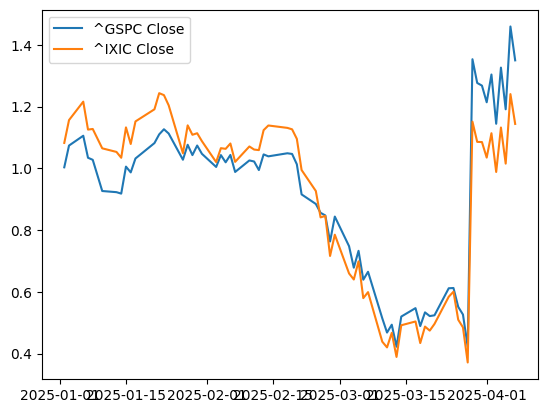

In [120]:
plot_time_frame_x2(2025, 2025, result_df, '^GSPC Close', '^IXIC Close')